In [ ]:
# This notebook performs a statistical analysis on the learning rates between two groups of mice,
# and generates publication-ready figures. It is split in 3 parts:

# 1. Load requirements and basic exploration of the data
# 2. Model fitting of individual mice, comparison of parameters
#    and import of lesion data for each mouse from image analysis to remove individual mice from the study
# 3. Statistical analysis between the groups to conclude differences and points of divergence in learning

In [ ]:
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%pip install git+file:///content/APE_paper
%cd APE_paper/doc/figures_notebooks

In [2]:
%load_ext autoreload
%autoreload 2
from APE_paper.utils import plot_utils
from APE_paper.utils import custom_functions as cuf
import os
import sys
from APE_paper.utils.misc_utils import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
#from itertools import chains
from scipy import stats
import scipy.optimize as opt
import random
from IPython.display import clear_output
from datetime import date
from sklearn.linear_model import LinearRegression
from itertools import chain
clear_output()

In [3]:
# This dataset has been pre-processed, but conditions have not been selected
# This preprocessing includes removal of disengaged trials
# removal of the first 5 trials of each session
# capped at 5000 trials

# load the dataset
dataset_path = '../datasets/Chronic_lesions_dataframe.pkl'
df_to_plot = pd.read_pickle(dataset_path)

# parameters for the plotting
hue_order = ['Control', 'Lesion']
color_palette = [(0.24715576, 0.49918708, 0.57655991), (160/255, 11/255 , 11/255)]
sns.set_palette(color_palette)

In [5]:
# maximum number of trials performed per mouse in the dataset:
df_to_plot.groupby(['AnimalID', 'ExperimentalGroup', 'Protocol']).max()['CumulativeTrialNumberByProtocol']

AnimalID  ExperimentalGroup  Protocol
CL-14     Lesion             Auditory    4936.0
CL-15     Lesion             Auditory    4999.0
CL-16     Lesion             Auditory    4968.0
CL-17     Lesion             Auditory    4999.0
CL-18     Lesion             Auditory    4922.0
CL-19     Lesion             Auditory    4999.0
CL-20     Lesion             Auditory    4534.0
CL-21     Lesion             Auditory    4999.0
CL-22     Lesion             Auditory    4999.0
CL-23     Lesion             Auditory    4999.0
CL-24     Lesion             Auditory    4999.0
CL-25     Control            Auditory    4999.0
CL-26     Control            Auditory    4452.0
CL-27     Control            Auditory    4999.0
CL-29     Control            Auditory    4999.0
LFP16     Control            Auditory    4999.0
LFP17     Control            Auditory    4999.0
LFP18     Control            Auditory    4999.0
LFP19     Control            Auditory    4999.0
LFP20     Control            Auditory    4999.0
LF

#### Performance by session and 200-sized bins 

In [6]:
# bin trials every 200
df_to_plot["TrialIndexBinned200"] = (df_to_plot.CumulativeTrialNumberByProtocol // 200) * 200 + 100

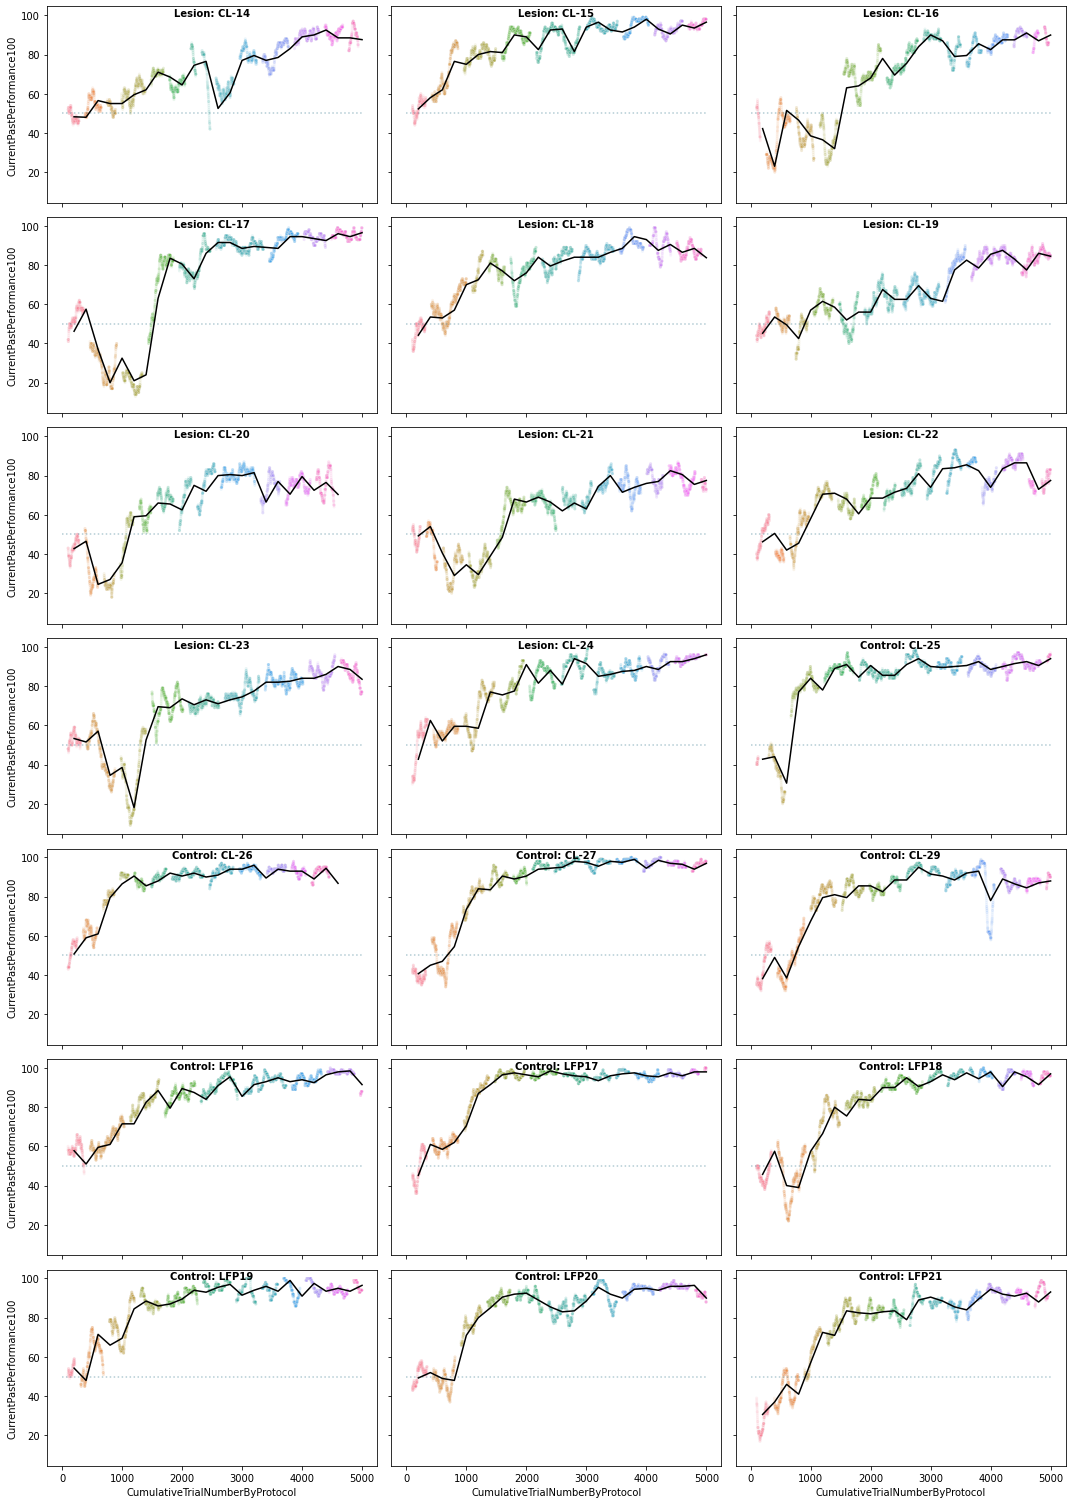

In [7]:
# Sanity check on the data to see that it looks good
ans_list = np.sort(df_to_plot.AnimalID.unique())
num_ans = len(ans_list)
fig, axs = plt.subplots(math.ceil(num_ans/3), 3,
                        figsize=(15, num_ans),
                        facecolor='w', edgecolor='k', sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < num_ans:
        ax.hlines(50, 0, 5000, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all animals
for counter, animal in enumerate(ans_list):
    ax = axs[counter]
    
    # plot here
    sns.scatterplot(data=df_to_plot[df_to_plot.AnimalID == animal],
                x="CumulativeTrialNumberByProtocol",
                y='CurrentPastPerformance100',
                marker='.',
                hue='SessionID',
                alpha=.1,
                ax=ax)
    
    # plot a line for binned trials
    sns.lineplot(x=df_to_plot[df_to_plot.AnimalID == animal]["TrialIndexBinned200"] + 100, #trick to align as
                 #CurrentPastPerformance looks at the past 
                 y=100 * df_to_plot[df_to_plot.AnimalID == animal]["FirstPokeCorrect"],
                 color='k',
                 ci=None,
                 ax=ax)
    
    
    ax.get_legend().remove()
    ec = df_to_plot[df_to_plot.AnimalID == animal].ExperimentalGroup.unique()[0]
    ax.text(.5,.95, ec + ': ' + animal, horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

    ax.axis('on')

    plt.tight_layout()

    update_progress(counter / num_ans)
    
update_progress(1)
# plt.savefig(data_directory + 'Performance_by_session_individual_animals.pdf', transparent=True, bbox_inches='tight')
clear_output()
plt.show(fig)

Colored dots show the performance of the past 100 trials using an average running window. Each color represents a distinct session. The black line shows the performance value of the past 200 trials using trial bining.

#### Fit a sigmoid to every mouse to calculate and compare stages and learning rates

In [9]:
#calculate the maximum performance for every mouse based on the trials binned every 200
df_bin200tr = df_to_plot.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned200','Protocol']).median().reset_index()
mouse_max_perf = df_bin200tr.groupby('AnimalID').max().reset_index()[['AnimalID', 'CurrentPastPerformance100']]

In [13]:
# define the models for the fitting
# sigmoid function
def sigmoid_func(x, perf_end, slope, bias): 
    return (perf_end - 0.5) / (1 + np.exp(-slope * (x - bias))) + 0.5

# sigmoid function scaled
def sigmoid_func_sc(x, perf_end, slope, bias): 
    return (perf_end - 50) / (1 + np.exp(-slope * (x - bias))) + 50

# derivative function
def der_sig(x, perf_end, slope, bias):
    return (perf_end - 50) * slope * np.exp(- slope * (x - bias)) / (1 + np.exp(- slope * (x - bias)))**2

The sigmoid function is (perf_end - 0.5) / (1 + np.exp(-slope * (x - bias))) + 0.5

Data is scaled before the fitting and parameters are rescaled afterwards

The maximum performace possible is defined as the maximum of the median of the trials binned every 200 

In [14]:
ans_list = np.sort(df_to_plot.AnimalID.unique())
num_ans = len(ans_list)
# create a diccionary to store the results, and lists to rescale the data
fit_dir = {}
xmeans_list = []
xsd_list = []

# process data from all animals
for counter, animal in enumerate(ans_list):
    df = df_to_plot[df_to_plot.AnimalID==animal][
        ['CumulativeTrialNumberByProtocol',
         'CurrentPastPerformance100',
         'SessionID']
    ].dropna()
    
    # calculate and plot the fitting
    xdata = np.array(df.CumulativeTrialNumberByProtocol)
    ydata = np.array(df.CurrentPastPerformance100)
    
    # scale the data
    xdatasc = (xdata - xdata.mean()) / xdata.std()
    ydatasc = ydata / 100
    
    # limit to the maximum performance for this mouse:
    mp = mouse_max_perf[mouse_max_perf.AnimalID==animal].CurrentPastPerformance100.iloc[0] / 100

    cost_func = lambda x: np.mean(np.abs(sigmoid_func(xdatasc, x[0], x[1], x[2]) - ydatasc))
    res = opt.minimize(cost_func, [1, 0, 0], bounds=((0.5, mp), (0., 10.), (None,None)))

    update_progress(counter / num_ans)
    
    #update dicctionary and lists
    fit_dir[animal] = res
    xmeans_list.append(xdata.mean())
    xsd_list.append(xdata.std())
    
update_progress(1)

Progress: [####################] 100.0%


In [15]:
# convert to dataframe
fit_df = pd.DataFrame({
    'AnimalID': list(fit_dir.keys()),
    'maximum_performance': [v.x[0] for k, v in fit_dir.items()],
    'slope': [v.x[1] for k, v in fit_dir.items()],
    'bias': [v.x[2] for k, v in fit_dir.items()]
})
# get the Experimental procedure
fit_df['ExperimentalGroup'] = fit_df['AnimalID'].apply(
        lambda x: df_to_plot[df_to_plot.AnimalID==x].ExperimentalGroup.unique()[0]
    )
# rescale back the coefficients
fit_df.maximum_performance = fit_df.maximum_performance * 100
fit_df.slope = fit_df.slope / np.array(xsd_list)
fit_df.bias = fit_df.bias * np.array(xsd_list) + np.array(xmeans_list)

In [17]:
# find the steepest point of each slope (max of derivative)
der_max_dir = {}
for animal in ans_list:
    m_point = opt.fmin(lambda x: -der_sig(x, *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                               fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                               fit_df[fit_df.AnimalID==animal].bias.iloc[0]]), 0, full_output=True)
    
    der_max_dir[animal] = (m_point[0][0], -m_point[1])
clear_output()

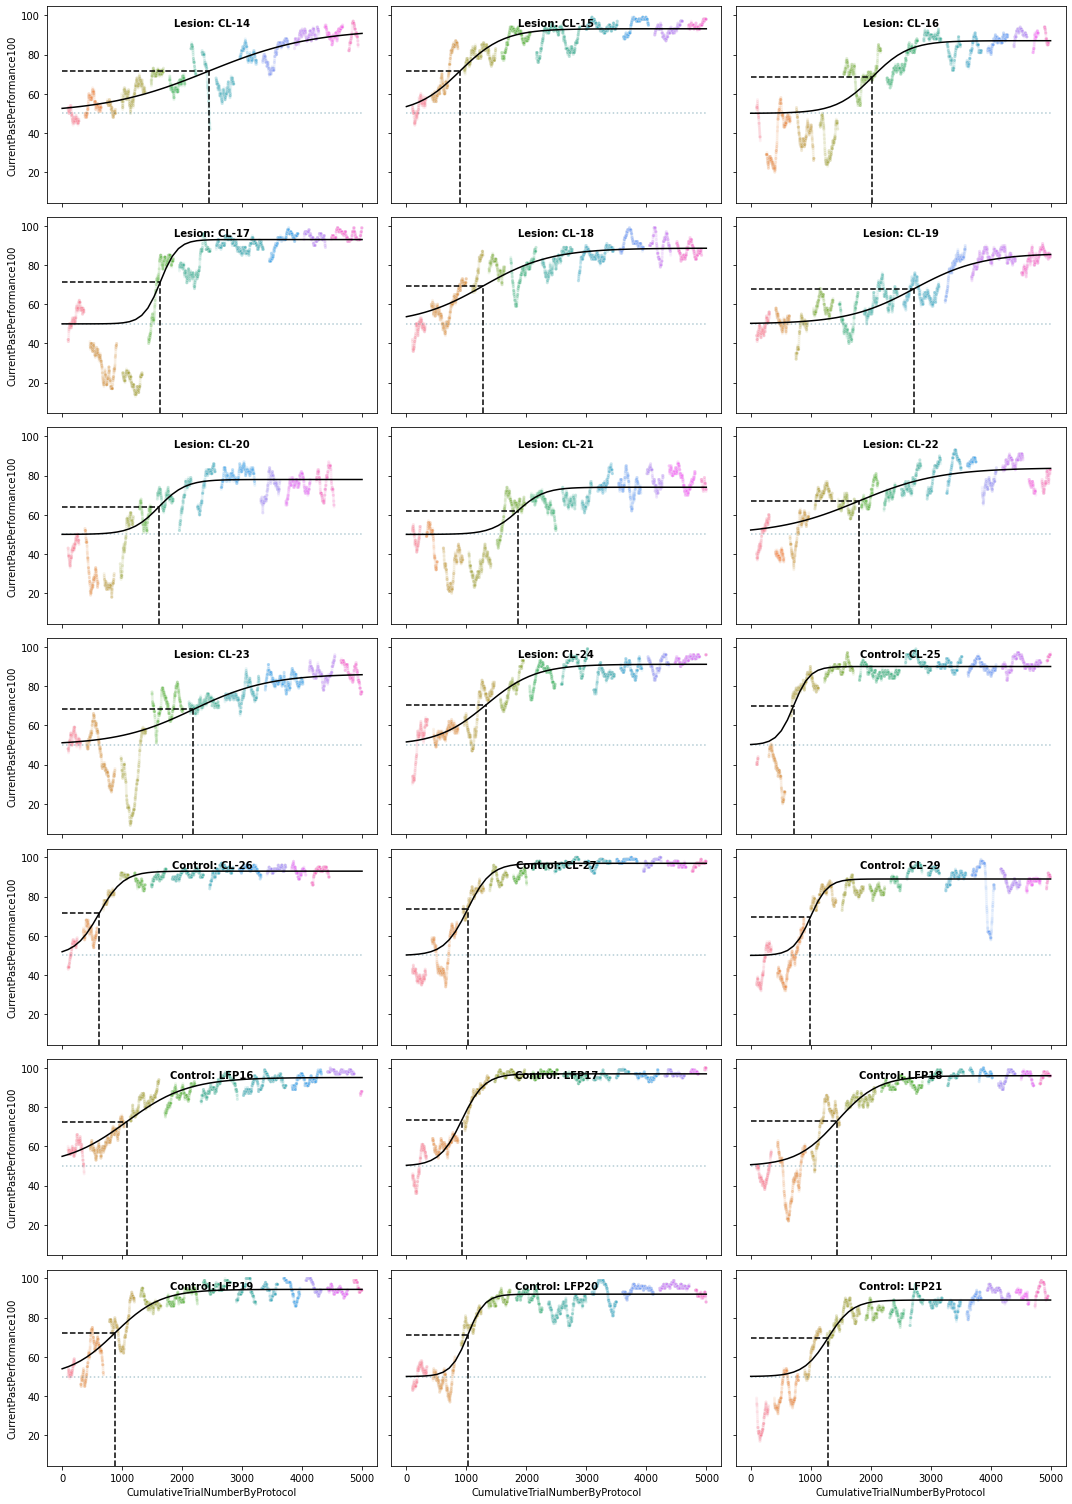

In [20]:
# plot the curves again pointing to the maximum
# sanity check to see that these scaled values recreate the curves

x = np.linspace(1,5000)

fig, axs = plt.subplots(math.ceil(num_ans/3), 3,
                        figsize=(15, num_ans),
                        facecolor='w', edgecolor='k', sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < num_ans:
        ax.hlines(50, 0, 5000, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all animals
for counter, animal in enumerate(ans_list):
    ax = axs[counter]
    df = df_to_plot[df_to_plot.AnimalID==animal][
        ['CumulativeTrialNumberByProtocol',
         'CurrentPastPerformance100',
         'SessionID']
    ].dropna()
    
    # plot here
    sns.scatterplot(data=df,
                x="CumulativeTrialNumberByProtocol",
                y='CurrentPastPerformance100',
                marker='.',
                hue='SessionID',
                alpha=.1,
                ax=ax)
    
    sns.lineplot(x=x,
                 y=sigmoid_func_sc(x, *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].bias.iloc[0]]),
                 color='k',
                 ci=None,
                 ax=ax)
    
    ax.get_legend().remove()
    ec = df_to_plot[df_to_plot.AnimalID == animal].ExperimentalGroup.unique()[0]
    ax.text(.5,.9, ec + ': ' + animal, horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

    ax.axis('on')

    plt.tight_layout()

    update_progress(counter / num_ans)


# point to the maximum slope
ymin, ymax = plt.gca().get_ybound()
for counter, animal in enumerate(ans_list):
    ax = axs[counter] 
    perc_max_slope = sigmoid_func_sc(der_max_dir[animal][0],
                                     *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                       fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                       fit_df[fit_df.AnimalID==animal].bias.iloc[0]])
    ax.axvline(fit_df[fit_df.AnimalID==animal].bias.iloc[0], 0, (perc_max_slope - ymin) / (ymax - ymin), linestyle='--', color='k')
    ax.plot([0, fit_df[fit_df.AnimalID==animal].bias.iloc[0]], [perc_max_slope,perc_max_slope], 'k--')
    
update_progress(1)
# plt.savefig(data_directory + 'Sigmoid_fitting.pdf', transparent=True, bbox_inches='tight')
clear_output()
plt.show(fig)

As a learning speed measure I use the point of the maximum learning rate, which is the maximum of the derivative of the fitting, which is also the middle point of the curve (in between 50% and maximum performance)
The bias indicates where this point lies in the x axis: at which trial number this point is reached

In [21]:
# add the maximum value of the derivative to the fit_df dataframe
for key, value in der_max_dir.items():
    fit_df.loc[fit_df.index[fit_df['AnimalID'] == key].tolist()[0], 'max_of_der'] = value[1]

### Differences of parameters between groups

In [24]:
# calculate significance
parameters_to_show = ['maximum_performance', 'max_of_der', 'bias']
# define three levels of significance for the plotting
sig_levels = [0.05, 0.01, 0.001]
pvals = []
print('Kluskal-Wallis tests on the parameters')
for var in parameters_to_show:
    kt = stats.kruskal(fit_df[fit_df.ExperimentalGroup==hue_order[0]][var].dropna(),
                       fit_df[fit_df.ExperimentalGroup==hue_order[1]][var].dropna())
    print( var + ':\t\tpvalue: ' + str(kt.pvalue) )
    pvals.append(kt.pvalue)

Kluskal-Wallis tests on the parameters
maximum_performance:		pvalue: 0.006027212132533926
max_of_der:		pvalue: 0.009175057794789263
bias:		pvalue: 0.001530672873555768


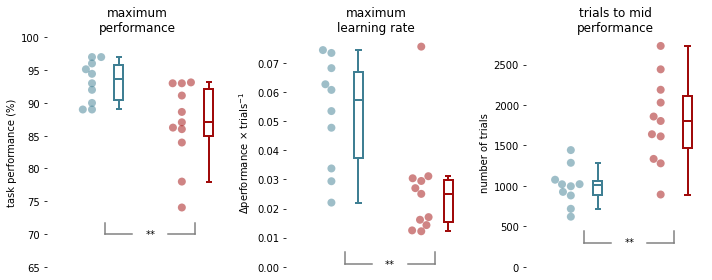

In [28]:
# compare the parameters between groups
titles = ['maximum\nperformance', 'maximum\nlearning rate', 'trials to mid\nperformance']
ylabs = ['task performance (%)', '\u0394performance \u00D7 trials$\mathregular{^{-1}}$',\
         'number of trials']
spread=.3

fig, axs = plt.subplots(ncols=3, nrows=1, sharey=False, figsize=(10,4))
axs = axs.ravel()
for i, var in enumerate(parameters_to_show):
    
    sns.swarmplot(data=fit_df,
                  x='ExperimentalGroup',
                  y=var,
                  order=hue_order,
                  hue='ExperimentalGroup',
                  hue_order=hue_order,
                  dodge=False, #jitter=.25,
                  alpha=.5, zorder=1, size=8,
                  ax=axs[i])
    
    # boxplot next to it
    for k, egr in enumerate(hue_order):
        bpdat = fit_df[fit_df.ExperimentalGroup == egr][var].values
        bp = axs[i].boxplot([bpdat], positions=[k+spread], widths=0.1, 
                            patch_artist=True, showfliers=False)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=LSpalette[k], linewidth=2)
        for patch in bp['boxes']:
            patch.set(facecolor='white')
    
    
    axs[i].set_title(titles[i])
    axs[i].set_ylabel(ylabs[i])
    
for ax in axs:
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Only show ticks on the left
    #ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks([])
    ax.xaxis.set_visible(False)

# fix individual axis
axs[0].set_ylim(65, 100)
axs[1].set_ylim(-0.00, axs[1].get_ylim()[1])
axs[2].set_ylim(0, axs[2].get_ylim()[1])

axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[0].get_legend().remove()

# add statistics
# for lesions
yvals = [70, 0.001, 300]

for i,ax in enumerate(axs):
    n_ast = sum(pvals[i] < sig_levels)
    plot_utils.add_stats(ax, xvals=(spread/2, 1+spread/2), yval=yvals[i], n_asterisks=n_ast)    

plt.tight_layout()
# plt.savefig(data_directory + 'Parameters_group_comparison.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [29]:
for i,s in enumerate(sig_levels):
    print(i+1, 'asterisks: pval <', s)

1 asterisks: pval < 0.05
2 asterisks: pval < 0.01
3 asterisks: pval < 0.001


### Assess difference in movement parameters

# CLEAN THIS TO WHAT WE DO SHOW!!!

In [36]:
# calculate ITIs

itis_list = []
for Sid in pd.unique(df_to_plot.SessionID):
    itis = cuf.itis_calculator(df_to_plot[df_to_plot.SessionID==Sid])
    itis_list.append(itis)
#     df_to_plot[df_to_plot.SessionID==Sid, 'ITI'] = itis
#     print(df_to_plot[df_to_plot.SessionID==Sid].shape)
#     print(len(itis))
# TrialStartTimestamp
df_to_plot['ITI'] = np.array(list(chain(*[x for x in itis_list])))

In [37]:
# compare values in between animals at a comparable performance level
df_by_an = df_to_plot[np.logical_and(df_to_plot.CumulativePerformance > 70, df_to_plot.CumulativePerformance < 80)].groupby(['AnimalID','ExperimentalGroup']).median().reset_index()

In [38]:
# calculate significance
columns_to_plot = ['NoOfCenterPokes', 'TrialInitiationTime',\
                   'MiddleWaitTime', 'ITI']
# define three levels of significance for the plotting
sig_levels = [0.05, 0.01, 0.001]
pvals = []
print('Kluskal-Wallis tests on the parameters')
for var in columns_to_plot:
    kt = stats.kruskal(df_by_an[df_by_an.ExperimentalGroup==hue_order[0]][var].dropna(),
                       df_by_an[df_by_an.ExperimentalGroup==hue_order[1]][var].dropna())
    print(var + ':\t\tpvalue: ' + str(kt.pvalue) )
    pvals.append(kt.pvalue)

Kluskal-Wallis tests on the parameters
NoOfCenterPokes:		pvalue: 0.5382526579885021
TrialInitiationTime:		pvalue: 0.7781953973603389
MiddleWaitTime:		pvalue: 0.03458172039069956
ITI:		pvalue: 0.3981027163512062


/home/hmvergara/anaconda3/envs/APE_paper/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


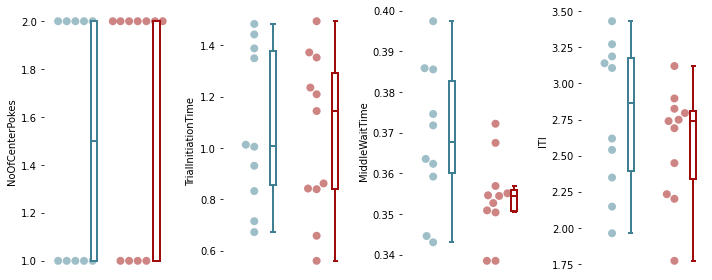

In [40]:
# compare the parameters between groups
spread=.3

fig, axs = plt.subplots(ncols=4, nrows=1, sharey=False, figsize=(10,4))
axs = axs.ravel()
for i, var in enumerate(columns_to_plot):
    
    sns.swarmplot(data=df_by_an,
                  x='ExperimentalGroup',
                  y=var,
                  order=hue_order,
                  hue='ExperimentalGroup',
                  hue_order=hue_order,
                  dodge=False, #jitter=.25,
                  alpha=.5, zorder=1, size=8,
                  ax=axs[i])
    
    # boxplot next to it
    for k, egr in enumerate(hue_order):
        bpdat = df_by_an[df_by_an.ExperimentalGroup == egr][var].values
        bp = axs[i].boxplot([bpdat], positions=[k+spread], widths=0.1, 
                            patch_artist=True, showfliers=False)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=LSpalette[k], linewidth=2)
        for patch in bp['boxes']:
            patch.set(facecolor='white')
    
for ax in axs:    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Only show ticks on the left
    #ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks([])
    ax.xaxis.set_visible(False)


# axs[2].set_ylim(0, axs[2].get_ylim()[1])
# axs[3].set_ylim(0, axs[3].get_ylim()[1])


axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[0].get_legend().remove()
axs[3].get_legend().remove()

# add statistics
# for 6OHDA
# yvals = [75, 0.003, 500, 0.01]
# for D1 pre
# yvals = [40, -0.005, 500]
# for lesions
# yvals = [65, 0.001, 300, 0.01]

# for i,ax in enumerate(axs):
#     n_ast = sum(pvals[i] < sig_levels)
#     plot_utils.add_stats(ax, xvals=(spread/2, 1+spread/2), yval=yvals[i], n_asterisks=n_ast)    

plt.tight_layout()
# plt.savefig(data_directory + 'Motor_Parameters_group_comparison_median.pdf', transparent=True, bbox_inches='tight')
plt.show()

#### calculate the statistical differences of performances between groups at different points in learning time

#### Do not consider trials in which the animal is too biased to calculate performance, as the antibias acts making the mice be worse than chance and that can obscure effects of learning

In [42]:
bias_top_threshold = np.nanmean(df_to_plot.RightBias) + 2 * np.nanstd(df_to_plot.RightBias)
bias_bottom_threshold = np.nanmean(df_to_plot.RightBias) - 2 * np.nanstd(df_to_plot.RightBias)

bias_mask = np.logical_and(df_to_plot.RightBias < bias_top_threshold, df_to_plot.RightBias > bias_bottom_threshold)

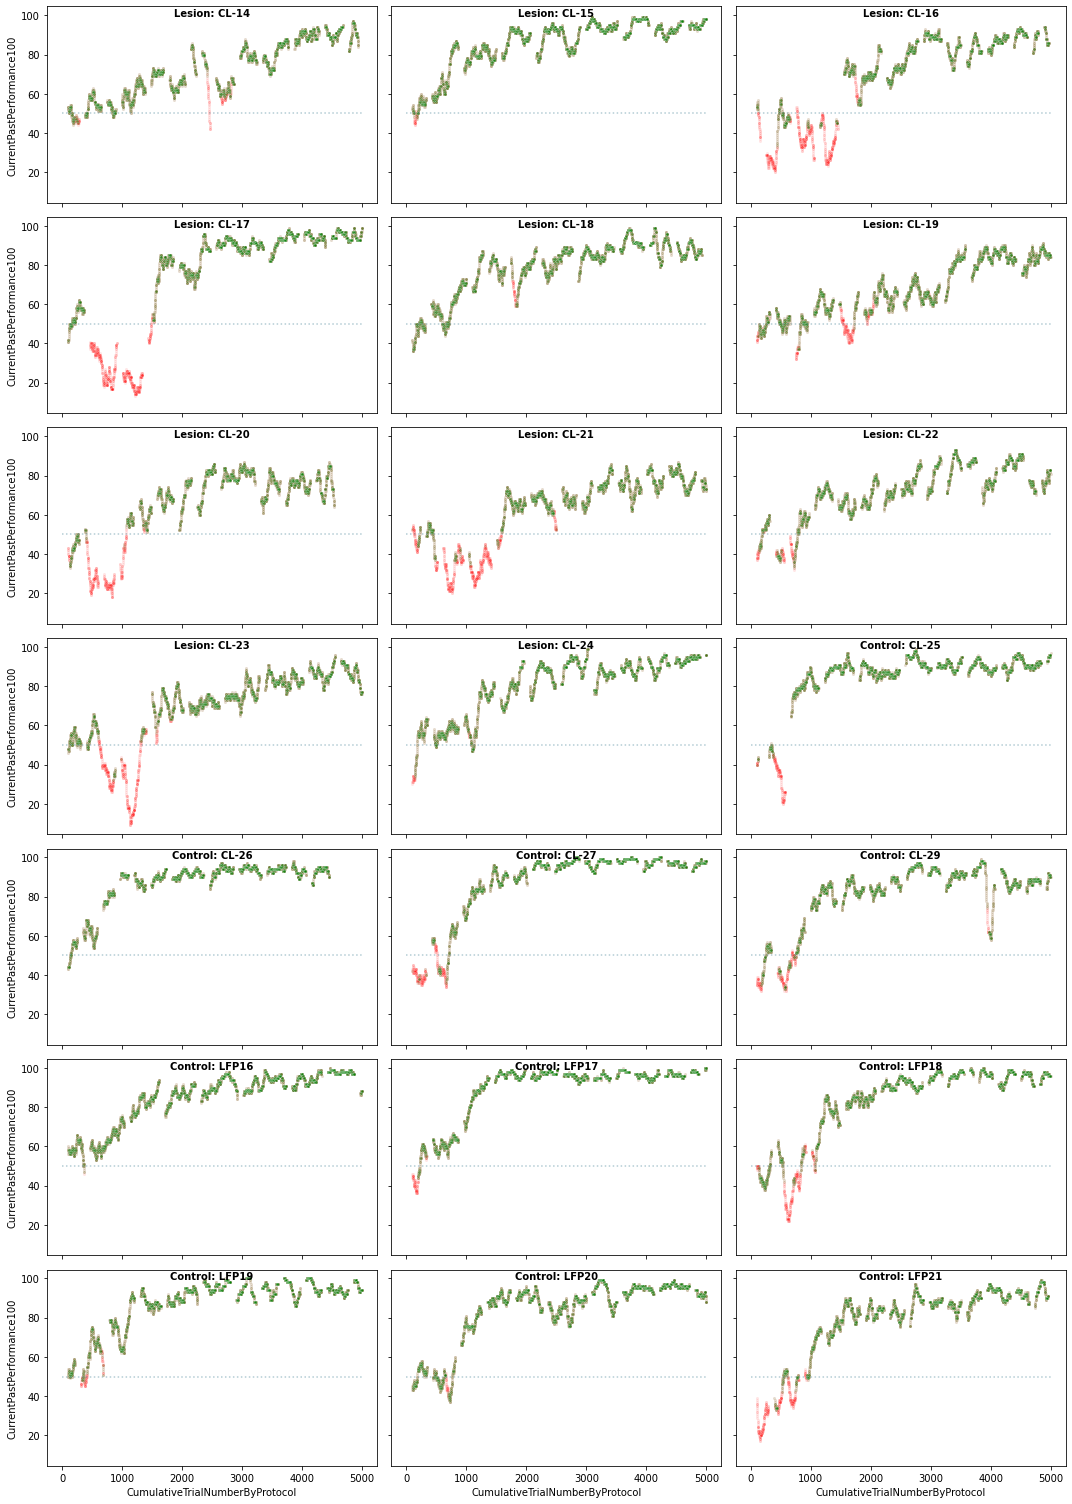

In [43]:
# Sanity check on the data to see that it looks good
ans_list = np.sort(df_to_plot.AnimalID.unique())
num_ans = len(ans_list)
fig, axs = plt.subplots(math.ceil(num_ans/3), 3,
                        figsize=(15, num_ans),
                        facecolor='w', edgecolor='k', sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < num_ans:
        ax.hlines(50, 0, 5000, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all animals
for counter, animal in enumerate(ans_list):
    ax = axs[counter]
    
    # plot here
    sns.scatterplot(data=df_to_plot[df_to_plot.AnimalID == animal],
                x="CumulativeTrialNumberByProtocol",
                y='CurrentPastPerformance100',
                marker='.',
                color='red',
                alpha=.1,
                ax=ax)
    
    sns.scatterplot(data=df_to_plot[np.logical_and(df_to_plot.AnimalID == animal, bias_mask)],
                x="CumulativeTrialNumberByProtocol",
                y='CurrentPastPerformance100',
                marker='.',
                color='green',
                alpha=.1,
                ax=ax)
    
    
#     ax.get_legend().remove()
    ec = df_to_plot[df_to_plot.AnimalID == animal].ExperimentalGroup.unique()[0]
    ax.text(.5,.95, ec + ': ' + animal, horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

    ax.axis('on')

    plt.tight_layout()

    update_progress(counter / num_ans)
    
update_progress(1)
# plt.savefig(data_directory + 'Performance_by_session_individual_animals_bias-removal.pdf', transparent=True, bbox_inches='tight')
clear_output()
plt.show(fig)

#### Recalculate performance

In [46]:
PAST_WINDOW = 100
CumPerList = []
for Sid in pd.unique(df_to_plot['SessionID']):
    CumPerList.append(cuf.perf_window_calculator(df_to_plot[np.logical_and(bias_mask,
                                                                           df_to_plot['SessionID']==Sid)],
                                                 PAST_WINDOW))
# flatten the list of lists
df_to_plot.loc[bias_mask, 'CurrentPastPerformance100biasremoved'] = np.array(list(chain(*[x for x in CumPerList])))

Shaded area indicates std, and performance is calculated using CurrentPastPerformance100biasremoved


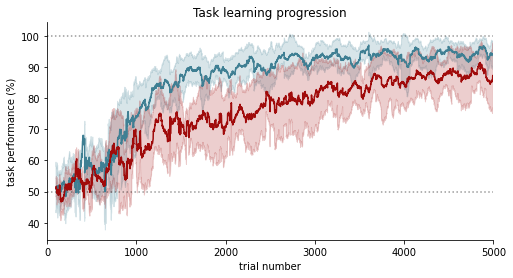

In [47]:
# Figure1X
col_to_plot = 'CurrentPastPerformance100biasremoved'
data_mean = df_to_plot.groupby(['CumulativeTrialNumberByProtocol','ExperimentalGroup'])[col_to_plot].mean().reset_index()
st_err_mean = df_to_plot.groupby(['CumulativeTrialNumberByProtocol','ExperimentalGroup'])[col_to_plot].std().reset_index()
data_mean['low_bound'] = data_mean[col_to_plot] - st_err_mean[col_to_plot]
data_mean['high_bound'] = data_mean[col_to_plot] + st_err_mean[col_to_plot]

fig1 = plt.figure(figsize=(8, 4))
plt.axhline(50, ls='dotted', alpha=0.4, color='k')
plt.axhline(100, ls='dotted', alpha=0.4, color='k')
for i,eg in enumerate(hue_order):
    df = data_mean[data_mean.ExperimentalGroup==eg].copy()
    x = df.CumulativeTrialNumberByProtocol
    plt.plot(x, df[col_to_plot], color=LSpalette[i], label=eg)
    #plt.plot(data_mean[data_mean.ExperimentalGroup==eg][col_to_plot], linestyle='--', color=LSpalette[i], label='95% ci')
    #plt.plot(neg_ci, linestyle='--', color='k')
    y1 = df['low_bound']
    y2 = df['high_bound']
    plt.fill_between(x, y1, y2, where=y2 >= y1, color=LSpalette[i], alpha=.2, interpolate=False)

plt.ylabel(col_to_plot)
plt.xlabel('trial number')
plt.ylabel('task performance (%)')
plt.legend(loc=(0.76,0.3), frameon=False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# remove the legend as the figure has it's own
ax.get_legend().remove()

ax.set_xlim((0,5000))

plt.title('Task learning progression')

# plt.savefig(data_directory + 'Performance_between_groups.pdf', transparent=True, bbox_inches='tight')
fig1.show()
print('Shaded area indicates std, and performance is calculated using', col_to_plot)

In [48]:
# define a 100-trial window to bin the data
xbin = 100
df_to_plot["TrialIndexBinned"] = (df_to_plot.CumulativeTrialNumberByProtocol // xbin) * xbin + xbin / 2
print('Trials are binned in groups of', xbin)

Trials are binned in groups of 100


In [49]:
# groupby so each animal has a mean of the performance in each bin
df_bintr = df_to_plot.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned','Protocol']).mean().reset_index()

In [50]:
# create a scaled version of the performance
df_bintr['Performance'] = df_bintr.FirstPokeCorrect * 100

In [52]:
# calculate the differences of the means using the binned data
perdif_df = df_bintr[df_bintr.ExperimentalGroup == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
            df_bintr[df_bintr.ExperimentalGroup == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance']

Now can measure the differences between the means of the two groups

#### Calculate the significance by resampling: suffle the group labels multiple times and calculate the likelihood of observing this data
References:

Supplementary figure 4 in here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2562676/

See also methods here: https://www.biorxiv.org/content/10.1101/716274v3.full

In [109]:
# define a function to generate a list of experimental groups randomly
def generate_eg(list_size, prob, labs = hue_order):
    ltr = []
    for i in range(list_size):
        if random.random() < prob:
            ltr.append(labs[0])
        else:
            ltr.append(labs[1])
    return ltr

In [110]:
# select the important columns
df_colsel = df_bintr[['AnimalID', 'ExperimentalGroup', 'TrialIndexBinned', 'Performance']].copy()
# get the experimental group for each animal
exp_gr = [df_colsel[df_colsel.AnimalID==x].ExperimentalGroup.unique()[0] for x in df_colsel.AnimalID.unique()]
# get the number of mice
n_an = len(exp_gr)
# get the probability of a mouse to be a control for this dataset
cb_prob = sum([x==hue_order[0] for x in exp_gr]) / n_an
# set random seed
np.random.seed(124321)
# calculate the differences of means by resampling
shuff_res = []
nsh = 10000
for i in range(nsh):
    # shuffle the list of groups by assigning a probability for each mouse to be in a group based on the real ratio
    exp_grs = generate_eg(n_an, cb_prob)
    # create a diccionary
    egs_dict = dict(zip(df_colsel.AnimalID.unique(), exp_grs))
    # create a new column with the shuffled group
    df_colsel['egs'] = [egs_dict[x] for x in df_colsel.AnimalID]
    # calculate the differences and append
    shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
                     df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
    update_progress(i / nsh)
# save in a data frame format
shrdf = pd.concat(shuff_res)
update_progress(1)
clear_output()

In [111]:
real_data = df_colsel[df_colsel.ExperimentalGroup == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
            df_colsel[df_colsel.ExperimentalGroup == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance']

The shuffling respects the proportion of mice in every group.

In [112]:
print('Data is shuffled', nsh, 'times')

Data is shuffled 10000 times


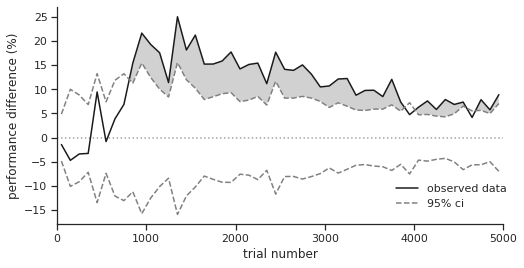

In [113]:
#plot
pos_ci = shrdf.groupby('TrialIndexBinned').quantile(.95)
neg_ci = shrdf.groupby('TrialIndexBinned').quantile(.05)

fig2 = plt.figure(figsize=(8, 4))
plt.axhline(0, ls='dotted', alpha=0.4, color='k')
plt.plot(real_data, color='k', label='observed data')
plt.plot(pos_ci, linestyle='--', color='gray', label='95% ci')
plt.plot(neg_ci, linestyle='--', color='gray')
x = pos_ci.reset_index().TrialIndexBinned
y1 = pos_ci.reset_index().Performance
y2 = real_data.reset_index().Performance
plt.fill_between(x, y1, y2, where=y2 >= y1, facecolor='k', alpha=.2, interpolate=True)
plt.ylabel('performance difference (%)')
plt.xlabel('trial number')
plt.legend(loc=(0.75,0.05), frameon=False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim((0,5000))

# plt.savefig(data_directory + 'Differences_of_means_significance_by_trial_bins.pdf',transparent=True, bbox_inches='tight')
fig2.show()

The red line shows the difference between the means in terms of performance.
The dotted lines show 95% confidence intervals for shuffled data.

This shows how likely is that each point crosses the line (point-base significance).

###### Substitute of the mixed anova: find the likelihood of any point being significant. Shuffle more data and quantify the percentage of times there is a crossing. Generate global bands of confidence

In [114]:
quants_to_test = [0.99, 0.995, 0.996, 0.997, 0.998, 0.999, 0.9999]
nsh=1000
# create an empty array to store results
global_sig = np.empty((nsh, len(quants_to_test)), dtype=bool)
# loop over shuffle data
for i in range(nsh):
    # shuffle the list of groups by assigning a probability for each mouse to be in a group based on the real ratio
    exp_grs = generate_eg(n_an, cb_prob)
    # create a diccionary
    egs_dict = dict(zip(df_colsel.AnimalID.unique(), exp_grs))
    # create a new column with the shuffled group
    df_colsel['egs'] = [egs_dict[x] for x in df_colsel.AnimalID]
    # calculate the differences
    sh_dif = df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
                     df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance']
    # for each quantile band, what percentages of lines cross at any point
    for k,q in enumerate(quants_to_test):
        global_sig[i,k] = any(np.logical_or(sh_dif > shrdf.groupby('TrialIndexBinned').quantile(q),
                                            sh_dif < shrdf.groupby('TrialIndexBinned').quantile(1 - q)))
        
    update_progress(i / nsh)
clear_output()

In [115]:
print('New shuffled data,', nsh, 'times')

New shuffled data, 1000 times


ci =  0.99 	global pval =  0.328 	real data significant  True
ci =  0.995 	global pval =  0.185 	real data significant  True
ci =  0.996 	global pval =  0.152 	real data significant  True
ci =  0.997 	global pval =  0.116 	real data significant  True
ci =  0.998 	global pval =  0.088 	real data significant  True
ci =  0.999 	global pval =  0.044 	real data significant  True
ci =  0.9999 	global pval =  0.005 	real data significant  True


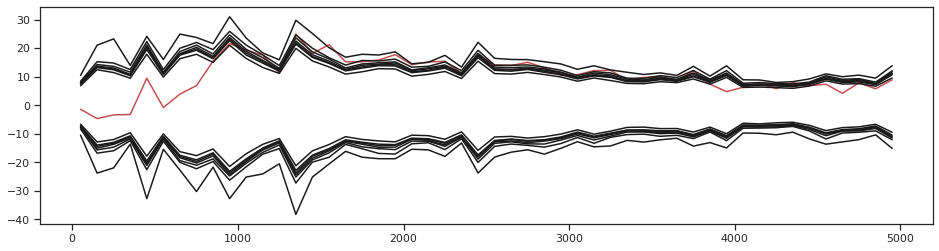

In [116]:
# plot the confidence intervals and print their global p-values:
plt.figure(figsize=(16, 4))
sns.lineplot(data=real_data, color='r')
for k,q in enumerate(quants_to_test):
    sns.lineplot(data=shrdf.groupby('TrialIndexBinned').quantile(q), color='k')
    sns.lineplot(data=shrdf.groupby('TrialIndexBinned').quantile((1 - q)), color='k')
    print('ci = ', q,
          '\tglobal pval = ',  np.sum(global_sig, axis=0)[k] / nsh,
          '\treal data significant ', any(np.logical_or(real_data > shrdf.groupby('TrialIndexBinned').quantile(q),
                                            real_data < shrdf.groupby('TrialIndexBinned').quantile(1 - q))))
plt.show()